# System and Library Setup for Emotion Classification using Transformers

In this notebook, we classify human emotions from text using transformer-based models (RoBERTa and XLNet). We begin by checking hardware specifications and installing essential libraries, including Hugging Face's `transformers` and `datasets` libraries, along with `ktrain` for simplified model training.


In [7]:
import tensorflow as tf
from psutil import virtual_memory

# Check GPU availability in Colab
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available: ", gpu_devices[0])
else:
    print("No GPU found. Please ensure GPU acceleration is enabled in Colab.")

# Check RAM availability
ram_gb = virtual_memory().total / 1e9
print(f'Available RAM: {ram_gb:.1f} GB\n')


No GPU found. Please ensure GPU acceleration is enabled in Colab.
Available RAM: 13.6 GB



# Install Required Libraries

We will install:
- **`ktrain`**: Simplifies the process of fine-tuning transformer models and predictions.
- **`transformers`**: Provides pre-trained transformer models like RoBERTa and XLNet.
- **`datasets`**: Allows easy access to datasets for NLP tasks, such as the Emotion dataset.

After installation, we’ll load the Emotion dataset.


In [8]:
# Install necessary libraries
!pip install ktrain transformers datasets


### Load Emotion Dataset

We load the Emotion dataset from Hugging Face, which contains text data labeled with six emotions: sadness, joy, love, anger, fear, and surprise. The dataset includes three splits: training, validation, and test.


In [9]:
from datasets import load_dataset

# Load the Emotion dataset
emotion_train = load_dataset('emotion', split='train')
emotion_val = load_dataset('emotion', split='validation')
emotion_test = load_dataset('emotion', split='test')

# Print dataset details
print(f"Train Dataset: {len(emotion_train)} samples")
print(f"Validation Dataset: {len(emotion_val)} samples")
print(f"Test Dataset: {len(emotion_test)} samples")


Train Dataset: 16000 samples
Validation Dataset: 2000 samples
Test Dataset: 2000 samples


# Dataset Exploration

Let’s inspect the dataset structure and explore the distribution of text samples across the six emotion categories. Additionally, we’ll convert the dataset into pandas DataFrames for easier manipulation.


In [10]:
import pandas as pd

# Convert dataset to pandas DataFrames
emotion_train_df = pd.DataFrame(emotion_train)
emotion_val_df = pd.DataFrame(emotion_val)
emotion_test_df = pd.DataFrame(emotion_test)

# Display sample rows from the training dataset
emotion_train_df.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


### Data Augmentation with Back-Translation

Back-translation is a data augmentation technique where text is translated into another language and then back into the original language. This helps improve the diversity and robustness of the training dataset while preserving the semantic meaning of the text.


In [11]:
from transformers import MarianMTModel, MarianTokenizer

# Function to perform back-translation
def back_translate(text, src_lang="en", tgt_lang="fr"):
    # Load translation model for src -> tgt
    tokenizer_src_tgt = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}")
    model_src_tgt = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}")
    # Translate to target language
    tgt_text = model_src_tgt.generate(**tokenizer_src_tgt(text, return_tensors="pt", padding=True))
    tgt_text_decoded = tokenizer_src_tgt.decode(tgt_text[0], skip_special_tokens=True)

    # Load translation model for tgt -> src
    tokenizer_tgt_src = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}")
    model_tgt_src = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}")
    # Translate back to source language
    src_text = model_tgt_src.generate(**tokenizer_tgt_src(tgt_text_decoded, return_tensors="pt", padding=True))
    return tokenizer_tgt_src.decode(src_text[0], skip_special_tokens=True)

# Example back-translation
sample_text = ["I am very happy with this result."]
augmented_text = back_translate(sample_text)
print(f"Original: {sample_text[0]}")
print(f"Back-Translated: {augmented_text}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limi

Original: I am very happy with this result.
Back-Translated: I am very pleased with this result.


In [12]:
import pandas as pd
from tqdm import tqdm

# Function to perform back-translation
def back_translate_text(text, src_lang="en", tgt_lang="fr"):
    try:
        # Load translation models
        tokenizer_src_tgt = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}")
        model_src_tgt = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}")

        tokenizer_tgt_src = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}")
        model_tgt_src = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}")

        # Translate to target language
        tgt_text = model_src_tgt.generate(**tokenizer_src_tgt(text, return_tensors="pt", padding=True))
        tgt_text_decoded = tokenizer_src_tgt.decode(tgt_text[0], skip_special_tokens=True)

        # Translate back to source language
        src_text = model_tgt_src.generate(**tokenizer_tgt_src(tgt_text_decoded, return_tensors="pt", padding=True))
        return tokenizer_tgt_src.decode(src_text[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error during back-translation for text: {text}. Skipping...")
        return text  # Return original text if back-translation fails

# Perform Back-Translation for Data Augmentation
def augment_data_with_back_translation(df, num_samples=100):
    print("Performing back-translation for data augmentation...")
    augmented_texts = []
    labels = []

    # Process only the first `num_samples` for demonstration purposes
    for index, row in tqdm(df.iloc[:num_samples].iterrows(), total=num_samples, desc="Back-Translating"):
        original_text = row["text"]
        label = row["label"]
        augmented_text = back_translate_text([original_text])  # Perform back-translation
        augmented_texts.append(augmented_text)
        labels.append(label)

    # Create a DataFrame for augmented data
    augmented_df = pd.DataFrame({
        "text": augmented_texts,
        "label": labels
    })

    # Combine with original data
    df_augmented = pd.concat([df, augmented_df]).reset_index(drop=True)
    return df_augmented

# Limit the number of samples for augmentation
emotion_train_df_augmented = augment_data_with_back_translation(emotion_train_df, num_samples=100)


print(f"Original training dataset size: {len(emotion_train_df)}")
print(f"Augmented training dataset size: {len(emotion_train_df_augmented)}")
print(emotion_train_df_augmented.head())

Performing back-translation for data augmentation...


Back-Translating: 100%|██████████| 100/100 [13:57<00:00,  8.38s/it]

Original training dataset size: 16000
Augmented training dataset size: 16100
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


### Dataset Statistics and Visualization

We will:
1. Check for missing values.
2. Create a new feature for text length.
3. Visualize the text length distribution across emotion labels.


Missing values in train set: text     0
label    0
dtype: int64


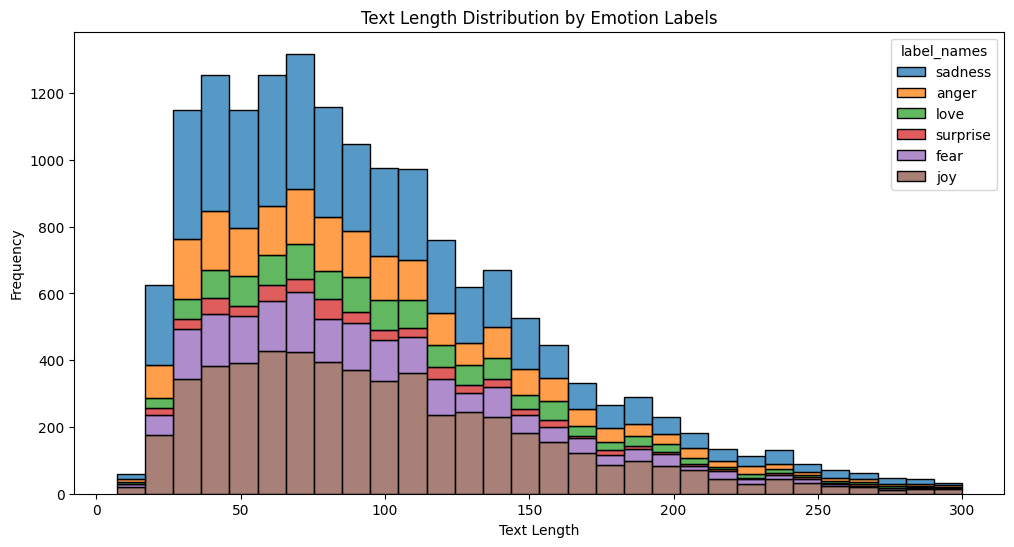

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print("Missing values in train set:", emotion_train_df.isnull().sum())

# Add text length as a new feature
emotion_train_df["text_length"] = emotion_train_df["text"].apply(len)

# Visualize text length distribution across emotion labels
emotion_train_df["label_names"] = emotion_train_df["label"].map({
    0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"
})

plt.figure(figsize=(12, 6))
sns.histplot(data=emotion_train_df, x="text_length", hue="label_names", multiple="stack", bins=30)
plt.title("Text Length Distribution by Emotion Labels")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


In [14]:
!pip install tensorflow==2.8.0 keras==2.8.0
!pip install ktrain --upgrade
!pip install protobuf==3.20.* transformers==4.28.0


In [15]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'


In [16]:
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'


In [18]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Define emotion labels
class_label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Load the RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(class_label_names))

print("RoBERTa tokenizer and model loaded successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceCla

RoBERTa tokenizer and model loaded successfully.


# Data Preprocessing for RoBERTa

We will tokenize the text data and convert it into input tensors (input IDs and attention masks) required for RoBERTa.


In [19]:
from datasets import load_dataset

# Reload Emotion dataset
emotion_train = load_dataset("emotion", split="train")
emotion_val = load_dataset("emotion", split="validation")
emotion_test = load_dataset("emotion", split="test")

# Check the number of samples in each split
print(f"Train Dataset: {len(emotion_train)} samples")
print(f"Validation Dataset: {len(emotion_val)} samples")
print(f"Test Dataset: {len(emotion_test)} samples")


Train Dataset: 16000 samples
Validation Dataset: 2000 samples
Test Dataset: 2000 samples


In [20]:
import pandas as pd

# Augment the training data using back-translation (only first 100 samples for speed)
emotion_train_df_augmented = augment_data_with_back_translation(emotion_train_df, num_samples=100)
emotion_val_df = pd.DataFrame(emotion_val)
emotion_test_df = pd.DataFrame(emotion_test)

# Check the first few rows of the training DataFrame
print(emotion_train_df.head())


Performing back-translation for data augmentation...


Back-Translating:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. W

                                                text  label  text_length  \
0                            i didnt feel humiliated      0           23   
1  i can go from feeling so hopeless to so damned...      0          108   
2   im grabbing a minute to post i feel greedy wrong      3           48   
3  i am ever feeling nostalgic about the fireplac...      2           92   
4                               i am feeling grouchy      3           20   

  label_names  
0     sadness  
1     sadness  
2       anger  
3        love  
4       anger  


In [21]:
import torch
from torch.utils.data import Dataset

# Define a custom dataset class for preprocessing
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Set max sequence length
max_len = 128


# Create datasets with augmented training data for RoBERTa
train_dataset = EmotionDataset(
    emotion_train_df_augmented["text"].tolist(),
    emotion_train_df_augmented["label"].tolist(),
    roberta_tokenizer,
    max_len
)

val_dataset = EmotionDataset(
    emotion_val_df["text"].tolist(),
    emotion_val_df["label"].tolist(),
    roberta_tokenizer,
    max_len
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 16100
Validation dataset size: 2000


In [22]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("Data loaders created successfully.")


Data loaders created successfully.


In [23]:
from torch.optim import AdamW
from transformers import get_scheduler

# Define training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        # Move batch data to the device (GPU/CPU)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Define evaluation function
def eval_epoch(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Move batch data to the device (GPU/CPU)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [24]:
# Move the model to the device (GPU/CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
roberta_model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(roberta_model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

print("Training setup complete.")


Training setup complete.


In [25]:
# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train the model
    train_loss = train_epoch(roberta_model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")

    # Evaluate the model
    val_loss, val_accuracy = eval_epoch(roberta_model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/3
Training Loss: 0.5801
Validation Loss: 0.2175
Validation Accuracy: 0.9220
Epoch 2/3
Training Loss: 0.1821
Validation Loss: 0.1396
Validation Accuracy: 0.9330
Epoch 3/3
Training Loss: 0.1296
Validation Loss: 0.1380
Validation Accuracy: 0.9345


In [26]:
# Save the fine-tuned model
torch.save(roberta_model.state_dict(), "roberta_emotion_model_augmented.pth")
print("Updated RoBERTa model saved.")


Updated RoBERTa model saved.


In [27]:
# Create test dataset and data loader
test_dataset = EmotionDataset(
    emotion_test_df["text"].tolist(),
    emotion_test_df["label"].tolist(),
    roberta_tokenizer,
    max_len
)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 2000


In [28]:
# Evaluate on test data
test_loss, test_accuracy = eval_epoch(roberta_model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1450
Test Accuracy: 0.9275


In [29]:
# Function to make predictions
def predict_emotion(text, model, tokenizer, device, max_len):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer(
            text,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        return class_label_names[prediction]

# Test on some examples
sample_text = "I am so happy and excited about this!"
predicted_emotion = predict_emotion(sample_text, roberta_model, roberta_tokenizer, device, max_len)
print(f"Text: {sample_text}")
print(f"Predicted Emotion: {predicted_emotion}")


Text: I am so happy and excited about this!
Predicted Emotion: joy


In [30]:
# Save the fine-tuned model for deployment
model_save_path = "roberta_emotion_model.pth"
torch.save(roberta_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to roberta_emotion_model.pth


### Fine-Tune XLNet for Emotion Classification

We will fine-tune XLNet, another transformer-based model, to classify emotions. Like RoBERTa, we will use the Hugging Face library to load the model and tokenizer.


In [31]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Initialize XLNet tokenizer and model
xlnet_tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
xlnet_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", num_labels=len(class_label_names)
)

# Move XLNet model to the device (GPU/CPU)
xlnet_model.to(device)

print("XLNet tokenizer and model initialized successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

XLNet tokenizer and model initialized successfully.


### Preprocessing Data for XLNet

We will use the XLNet tokenizer to tokenize the text data and convert it into input tensors (input IDs and attention masks) for XLNet.


In [32]:
# Create datasets for XLNet
train_dataset_xlnet = EmotionDataset(
    emotion_train_df_augmented["text"].tolist(),
    emotion_train_df_augmented["label"].tolist(),
    xlnet_tokenizer,
    max_len
)


val_dataset_xlnet = EmotionDataset(
    emotion_val_df["text"].tolist(),
    emotion_val_df["label"].tolist(),
    xlnet_tokenizer,
    max_len
)

print(f"Training dataset size (XLNet): {len(train_dataset_xlnet)}")
print(f"Validation dataset size (XLNet): {len(val_dataset_xlnet)}")


Training dataset size (XLNet): 16100
Validation dataset size (XLNet): 2000


### Create Data Loaders for XLNet

We will create data loaders for XLNet to handle batching and shuffling during training and validation.


In [33]:
# Create data loaders for XLNet
train_loader_xlnet = DataLoader(train_dataset_xlnet, batch_size=batch_size, shuffle=True)
val_loader_xlnet = DataLoader(val_dataset_xlnet, batch_size=batch_size)

print("Data loaders for XLNet created successfully.")


Data loaders for XLNet created successfully.


### Fine-Tuning XLNet

We will fine-tune XLNet using the training and validation data loaders, following a similar approach as RoBERTa.


In [34]:
# Define optimizer and scheduler for XLNet
optimizer_xlnet = AdamW(xlnet_model.parameters(), lr=2e-5)
num_training_steps_xlnet = len(train_loader_xlnet) * 3  # 3 epochs
scheduler_xlnet = get_scheduler(
    "linear", optimizer=optimizer_xlnet, num_warmup_steps=0, num_training_steps=num_training_steps_xlnet
)

# Training loop for XLNet
epochs_xlnet = 3
for epoch in range(epochs_xlnet):
    print(f"Epoch {epoch + 1}/{epochs_xlnet} for XLNet")
    # Train the model
    train_loss_xlnet = train_epoch(xlnet_model, train_loader_xlnet, optimizer_xlnet, scheduler_xlnet, device)
    print(f"Training Loss (XLNet): {train_loss_xlnet:.4f}")


    # Evaluate the model
    val_loss_xlnet, val_accuracy_xlnet = eval_epoch(xlnet_model, val_loader_xlnet, device)
    print(f"Validation Loss (XLNet): {val_loss_xlnet:.4f}")
    print(f"Validation Accuracy (XLNet): {val_accuracy_xlnet:.4f}")


Epoch 1/3 for XLNet
Training Loss (XLNet): 0.8653
Validation Loss (XLNet): 0.2894
Validation Accuracy (XLNet): 0.9040
Epoch 2/3 for XLNet
Training Loss (XLNet): 0.2469
Validation Loss (XLNet): 0.1819
Validation Accuracy (XLNet): 0.9235
Epoch 3/3 for XLNet
Training Loss (XLNet): 0.1617
Validation Loss (XLNet): 0.1696
Validation Accuracy (XLNet): 0.9270


### Save the Fine-Tuned XLNet Model

We will save the fine-tuned XLNet model to reuse it for predictions or to combine it with RoBERTa in an ensemble.


In [35]:
# Save the fine-tuned XLNet model
torch.save(xlnet_model.state_dict(), "xlnet_emotion_model_augmented.pth")
print("Updated XLNet model saved.")


Updated XLNet model saved.


### Ensemble Model: Combining RoBERTa and XLNet

We will combine predictions from RoBERTa and XLNet using a weighted voting approach. This enhances model performance by leveraging the strengths of both models.


In [36]:
#Function to compute ensemble predictions
def ensemble_predict(texts, roberta_model, xlnet_model, roberta_tokenizer, xlnet_tokenizer, device, max_len):
    """
    Predict emotions using an ensemble of fine-tuned RoBERTa and XLNet models.
    This function uses a weighted average of logits from both models.

    Args:
    - texts (list of str): List of input text samples for prediction.
    - roberta_model: Fine-tuned RoBERTa model.
    - xlnet_model: Fine-tuned XLNet model.
    - roberta_tokenizer: Tokenizer for RoBERTa.
    - xlnet_tokenizer: Tokenizer for XLNet.
    - device: Device to run predictions (CPU or GPU).
    - max_len (int): Maximum sequence length for tokenization.

    Returns:
    - final_predictions (list of int): Predicted emotion labels for each input text.
    """
    roberta_model.eval()
    xlnet_model.eval()

    final_predictions = []
    with torch.no_grad():
        for text in texts:
            # Tokenize and encode text for RoBERTa
            roberta_encoding = roberta_tokenizer(
                text,
                max_length=max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            roberta_input_ids = roberta_encoding["input_ids"].to(device)
            roberta_attention_mask = roberta_encoding["attention_mask"].to(device)
            roberta_logits = roberta_model(
                input_ids=roberta_input_ids,
                attention_mask=roberta_attention_mask
            ).logits

            # Tokenize and encode text for XLNet
            xlnet_encoding = xlnet_tokenizer(
                text,
                max_length=max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            xlnet_input_ids = xlnet_encoding["input_ids"].to(device)
            xlnet_attention_mask = xlnet_encoding["attention_mask"].to(device)
            xlnet_logits = xlnet_model(
                input_ids=xlnet_input_ids,
                attention_mask=xlnet_attention_mask
            ).logits

            # Adjust weights for the ensemble (optional)
            roberta_weight = 0.6  # Adjust weight for RoBERTa if required
            xlnet_weight = 0.4   # Adjust weight for XLNet if required

            # Weighted average of logits
            combined_logits = (roberta_weight * roberta_logits + xlnet_weight * xlnet_logits)
            final_prediction = torch.argmax(combined_logits, dim=1).item()
            final_predictions.append(final_prediction)

    return final_predictions


### Evaluate Ensemble Model

We will evaluate the ensemble model on the test dataset and calculate accuracy and metrics.


In [37]:
# Prepare test data
test_texts = emotion_test_df["text"].tolist()
test_labels = emotion_test_df["label"].tolist()

# Get ensemble predictions
ensemble_predictions = ensemble_predict(
    test_texts, roberta_model, xlnet_model, roberta_tokenizer, xlnet_tokenizer, device, max_len
)

# Calculate metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
ensemble_accuracy = accuracy_score(test_labels, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(test_labels, ensemble_predictions, target_names=class_label_names))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, ensemble_predictions))


Ensemble Accuracy: 0.9280
Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.98      0.92      0.95       695
        love       0.79      0.97      0.87       159
       anger       0.94      0.91      0.92       275
        fear       0.87      0.88      0.88       224
    surprise       0.71      0.77      0.74        66

    accuracy                           0.93      2000
   macro avg       0.87      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000

Confusion Matrix:
[[563   3   0   8   7   0]
 [  4 640  42   2   1   6]
 [  0   5 154   0   0   0]
 [ 13   2   0 250  10   0]
 [  4   0   0   7 198  15]
 [  3   0   0   0  12  51]]
